# Monte Carlo a Catena di Markov {#sec-metropolis}

**Prerequisiti**

**Concetti e competenze chiave**

- Utilizzare metodi di Monte Carlo per stimare valori attesi e probabilità, evitando calcoli di integrali complessi.
- Apprendere il ruolo delle catene di Markov per generare sequenze di campioni dalla distribuzione a posteriori.
- Implementare e comprendere l'algoritmo di Metropolis come strumento per il campionamento dalla distribuzione a posteriori.
- Valutare la convergenza delle catene di Markov e utilizzare strumenti come il trace plot e l'autocorrelazione per diagnosticare la qualità del campionamento.
- Riconoscere l'importanza della fase di burn-in e la necessità di più catene per verificare la stazionarietà e ridurre l'autocorrelazione.

**Preparazione del Notebook**

In [1]:
%run ../../config.py # Import the configuration settings
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

## Introduzione {.unnumbered}

In precedenza, abbiamo esplorato diversi esempi di inferenza bayesiana relativi alla distribuzione a posteriori di un singolo parametro, come nel caso del modello bernoulliano. Abbiamo anche discusso l'utilizzo di approcci come l'approssimazione tramite griglia e i metodi dei priori coniugati per ottenere o approssimare la distribuzione a posteriori. In questo capitolo, ci concentreremo sul metodo di simulazione e spiegheremo perché sono necessari approcci speciali noti come metodi di Monte Carlo a Catena di Markov (MCMC).

## Il denominatore bayesiano

Nell'approccio bayesiano, il nostro obiettivo principale è determinare la distribuzione a posteriori $p(\theta \mid y)$ di un parametro $\theta$, utilizzando sia i dati osservati $ y $ che la distribuzione a priori $p(\theta)$. Questo processo si basa sul teorema di Bayes:

$$
p(\theta \mid y) = \frac{p(y \mid \theta) p(\theta)}{\int p(y \mid \theta) p(\theta) d\theta}.
$$

In questa formula, il denominatore $\int p(y \mid \theta) p(\theta) d\theta$ rappresenta l'integrazione (o la somma, nel caso di variabili discrete) su tutti i possibili valori di $\theta$, fornendo così la probabilità marginale di $y$. Questo assicura che $ p(\theta \mid y) $ sia una distribuzione di probabilità valida che si integra (o si somma) a 1.

Tuttavia, spesso incontriamo una sfida significativa: il calcolo dell'evidenza $p(y) = \int p(y \mid \theta) p(\theta) d\theta$ può essere estremamente complesso, specialmente per modelli più articolati, rendendo difficile ottenere con precisione la distribuzione a posteriori.

Una soluzione possibile è rappresentata dalle distribuzioni a priori coniugate, che offrono un metodo analitico per determinare la distribuzione a posteriori. Tuttavia, questo limita la selezione delle distribuzioni a priori e di verosimiglianza.

Un metodo per superare questa limitazione è ricorrere a soluzioni numeriche, ma i metodi di campionamento a griglia sono applicabili solo nel caso di modelli con un numero di parametri molto piccolo.

La soluzione generale è utilizzare i Metodi di Monte Carlo a Catena di Markov (MCMC). Questi metodi consentono di derivare la distribuzione a posteriori basandosi su presupposti teorici e senza restrizioni nella scelta delle distribuzioni. L'approccio Monte Carlo si basa sulla generazione di sequenze di numeri casuali per creare un ampio campione di osservazioni dalla distribuzione a posteriori. Da questi campioni, possiamo poi stimare empiricamente le proprietà di interesse. Questo approccio richiede l'uso di metodi computazionalmente intensivi e, con la crescente potenza di calcolo dei computer moderni, tali metodi stanno diventando sempre più accessibili e popolari nell'analisi dei dati.

## Il Metodo di Monte Carlo

Nei capitoli precedenti abbiamo già esplorato l'efficacia della simulazione nel campo della teoria delle probabilità. Un esempio classico è il problema di Monty Hall, che mostra come la simulazione ripetuta possa fornire stime affidabili per la media e la varianza di variabili casuali. Inoltre, applicando la legge dei grandi numeri, queste stime diventano più accurate all'aumentare del numero di simulazioni. Ciò evidenzia la potenza dei metodi Monte Carlo, che evitano la necessità di calcolare integrali complessi.

Il Metodo di Monte Carlo, sviluppato durante il Progetto Manhattan negli anni '40, utilizza numeri casuali per risolvere problemi matematici complessi. Originariamente ideato da Stanislaw Ulam e successivamente implementato da John von Neumann, il metodo prende il nome dallo zio giocatore d'azzardo di Ulam, come suggerito da Nicholas Metropolis. Da allora, questo metodo è diventato una tecnica fondamentale in diverse discipline, contribuendo significativamente alla risoluzione di problemi complessi.

La metodologia di Monte Carlo genera un'ampia serie di punti casuali per stimare quantità di interesse, come l'integrazione numerica. Un esempio classico è l'approssimazione dell'integrale di un cerchio in 2D, dove il rapporto tra il numero di punti che cadono all'interno del cerchio e tutti i campioni fornisce un'approssimazione dell'area (per un esempio numerico, si veda @sec-montecarlo-integration).

Per illustrare ulteriormente questo concetto, consideriamo ora una distribuzione continua $p(\theta \mid y)$ con una media $\mu$. Se siamo in grado di generare una sequenza di campioni casuali $\theta^{(1)}, \theta^{(2)}, \dots, \theta^{(T)}$ indipendenti e identicamente distribuiti secondo $p(\theta \mid y)$, possiamo stimare il valore atteso teorico di $\theta$ utilizzando la media campionaria $\frac{1}{T} \sum_{i=1}^T \theta^{(t)}$. Questa approssimazione diventa sempre più accurata man mano che aumenta il numero di campioni $T$, grazie alla Legge Forte dei Grandi Numeri.

Un altro vantaggio del Metodo di Monte Carlo è la sua capacità di approssimare la probabilità che una variabile casuale $\theta$ cada all'interno di un intervallo specifico $(l, u)$. Questo può essere ottenuto calcolando la media campionaria della funzione indicatrice $I(l < \theta < u)$ per ogni realizzazione $\theta^{(t)}$, cioè $Pr(l < \theta < u) \approx \frac{\text{numero di realizzazioni } \theta^{(t)} \in (l, u)}{T}$.

Nonostante la loro efficacia, un limite dei metodi Monte Carlo tradizionali risiede nella generazione efficiente di un elevato numero di campioni $X_1, X_2, \ldots, X_n$. In risposta a questa sfida, i metodi di Monte Carlo basati su catene di Markov (MCMC) offrono una soluzione potente per simulare da distribuzioni complesse attraverso catene di Markov. L'evoluzione di questi algoritmi ha trasformato radicalmente la statistica e il calcolo scientifico, permettendo la simulazione da una vasta gamma di distribuzioni, anche in spazi di alta dimensionalità.

## Le Catene di Markov

Le catene di Markov, ideate da Andrey Markov nel 1906, rappresentano un tentativo di estendere la legge dei grandi numeri a contesti in cui le variabili casuali non sono indipendenti. Tradizionalmente, la statistica si concentra su sequenze di variabili casuali indipendenti e identicamente distribuite (i.i.d.), simboleggiate come $X_0, X_1, \ldots, X_n, \ldots$. In tali sequenze, ogni variabile è indipendente dalle altre e segue la stessa distribuzione, con $n$ che rappresenta un indice temporale discreto. Tuttavia, questa assunzione di indipendenza non è sempre realistica nei modelli di fenomeni complessi, portando alla necessità di esplorare forme alternative di dipendenza tra variabili.

Per superare le limitazioni dell'indipendenza, le catene di Markov introducono una cosiddetta "dipendenza a un passo", incarnata nella "proprietà di Markov". Questa proprietà stabilisce che la previsione di un evento futuro $X_{n+1}$ dipende unicamente dall'evento immediatamente precedente $X_n$, indipendentemente dagli eventi passati $X_0, X_1, X_2, \ldots, X_{n-1}$. La proprietà di Markov è espressa matematicamente come:

$$
P(X_{n+1} = j | X_n = i, X_{n-1} = i_{n-1}, \ldots, X_0 = i_0) = P(X_{n+1} = j | X_n = i).
$$

Questa proprietà afferma che la previsione di un evento futuro dipende solo dall'evento immediatamente precedente, semplificando i calcoli relativi alle probabilità condizionali.

Le catene di Markov rappresentano un framework fondamentale per la modellazione delle dipendenze tra variabili casuali, una nozione cruciale in numerosi campi della statistica e della scienza dei dati, inclusa la metodologia MCMC (Markov Chain Monte Carlo). In particolare, nell'ambito dell'analisi bayesiana, l'uso di MCMC si rivela di estrema importanza, soprattutto quando non è possibile calcolare in modo analitico la distribuzione a posteriori.

L'algoritmo di Metropolis rappresenta una delle implementazioni più semplici del metodo MCMC. Questo algoritmo sfrutta la natura dipendente delle catene di Markov per navigare in modo efficace attraverso lo spazio della distribuzione a posteriori. Questo aspetto rende il MCMC uno strumento di grande potenza per affrontare problemi complessi in cui i metodi analitici tradizionali non possono essere applicati (per ulteriori dettagli, si veda @sec-montecarlo-integration). In breve, il MCMC consente di generare un vasto insieme di valori per il parametro $\theta$. Idealmente, questi valori riflettono la distribuzione a posteriori $p(\theta \mid y)$ quando questa non può essere ottenuta direttamente. Questa caratteristica rende il MCMC uno strumento essenziale per risolvere problemi complessi in cui i metodi analitici convenzionali non sono applicabili.

## Estrazione di campioni dalla distribuzione a posteriori

Nella discussione seguente ci porremo l'obiettivo di comprendere come utilizzare l'algoritmo di Metropolis per approssimare la distribuzione a posteriori $p(\theta \mid y)$. A questo fine, il capitolo è strutturato in varie sezioni che facilitano la comprensione progressiva del tema. 

- Inizieremo discutendo di come la distribuzione a posteriori possa essere approssimata mediante tecniche di simulazione convenzionali. Questa prima parte presuppone che la distribuzione target, o "a posteriori," sia già conosciuta o disponibile per l'analisi.
- In seguito, passeremo a illustrare come l'algoritmo di Metropolis possa essere utilizzato per affrontare situazioni in cui la distribuzione a posteriori non è direttamente nota. In questi casi, spesso abbiamo a disposizione informazioni riguardanti la distribuzione a priori e la funzione di verosimiglianza, che possono essere utilizzate per ottenere un'approssimazione efficace della distribuzione a posteriori.

A titolo esemplificativo, utilizzeremo il dataset `moma_sample.csv`, il quale costituisce un campione casuale di 100 artisti provenienti dal Museo di Arte Moderna di New York (MoMA) e contiene diverse informazioni relative a ciascun artista.

Il nostro interesse è focalizzato sulla determinazione della probabilità che un artista presente nel MoMA appartenga alla generazione X o a una generazione successiva (nati dopo il 1965). Questa probabilità sarà indicata come $\pi$. Iniziamo importando i dati.

In [2]:
moma_sample = pd.read_csv("../../data/moma_sample.csv")

Esaminiamo le prime cinque righe del DataFrame.

In [3]:
moma_sample.head()

,artist,country,birth,death,alive,genx,gender,count,year_acquired_min,year_acquired_max
0,Ad Gerritsen,dutch,1940,2015.0,False,False,male,1,1981,1981
1,Kirstine Roepstorff,danish,1972,NaN,True,True,female,3,2005,2005
2,Lisa Baumgardner,american,1958,2015.0,False,False,female,2,2016,2016
3,David Bates,american,1952,NaN,True,False,male,1,2001,2001
4,Simon Levy,american,1946,NaN,True,False,male,1,2012,2012


Dai dati osserviamo che solo 14 artisti su 100 appartengono alla generazione X o a una generazione successiva.

In [4]:
result = moma_sample["genx"].value_counts()
print(result)

genx
False    86
True     14
Name: count, dtype: int64


Il valore campionato $y = 14$ riflette le caratteristiche del campione che è stato osservato. Tuttavia, poiché il MOMA contiene opere di migliaia di artisti, sorge una domanda riguardante il vero valore di $\theta$ (la probabilità di appartenere alla generazione X o a una generazione successiva) all'interno di questa popolazione.

Possiamo interpretare i dati $y = 14$ come l'esito di una variabile casuale Binomiale con parametri $N = 100$ e $\theta$ sconosciuto.

Supponiamo che le nostre credenze pregresse riguardo a $\theta$ possano essere modellate attraverso una distribuzione Beta(4, 6).

Sfruttando le proprietà delle distribuzioni coniugate, possiamo calcolare la distribuzione a posteriori esatta:

```python
Y ~ Binomiale(100, π)
θ = Beta(4, 6)
θ | (Y = 14) ~ Beta(4 + 14, 6 + 100 - 14) → Beta(18, 92)
```

Nella figura successiva è rappresentata la distribuzione a posteriori del parametro $\theta$, insieme alla distribuzione a priori scelta.

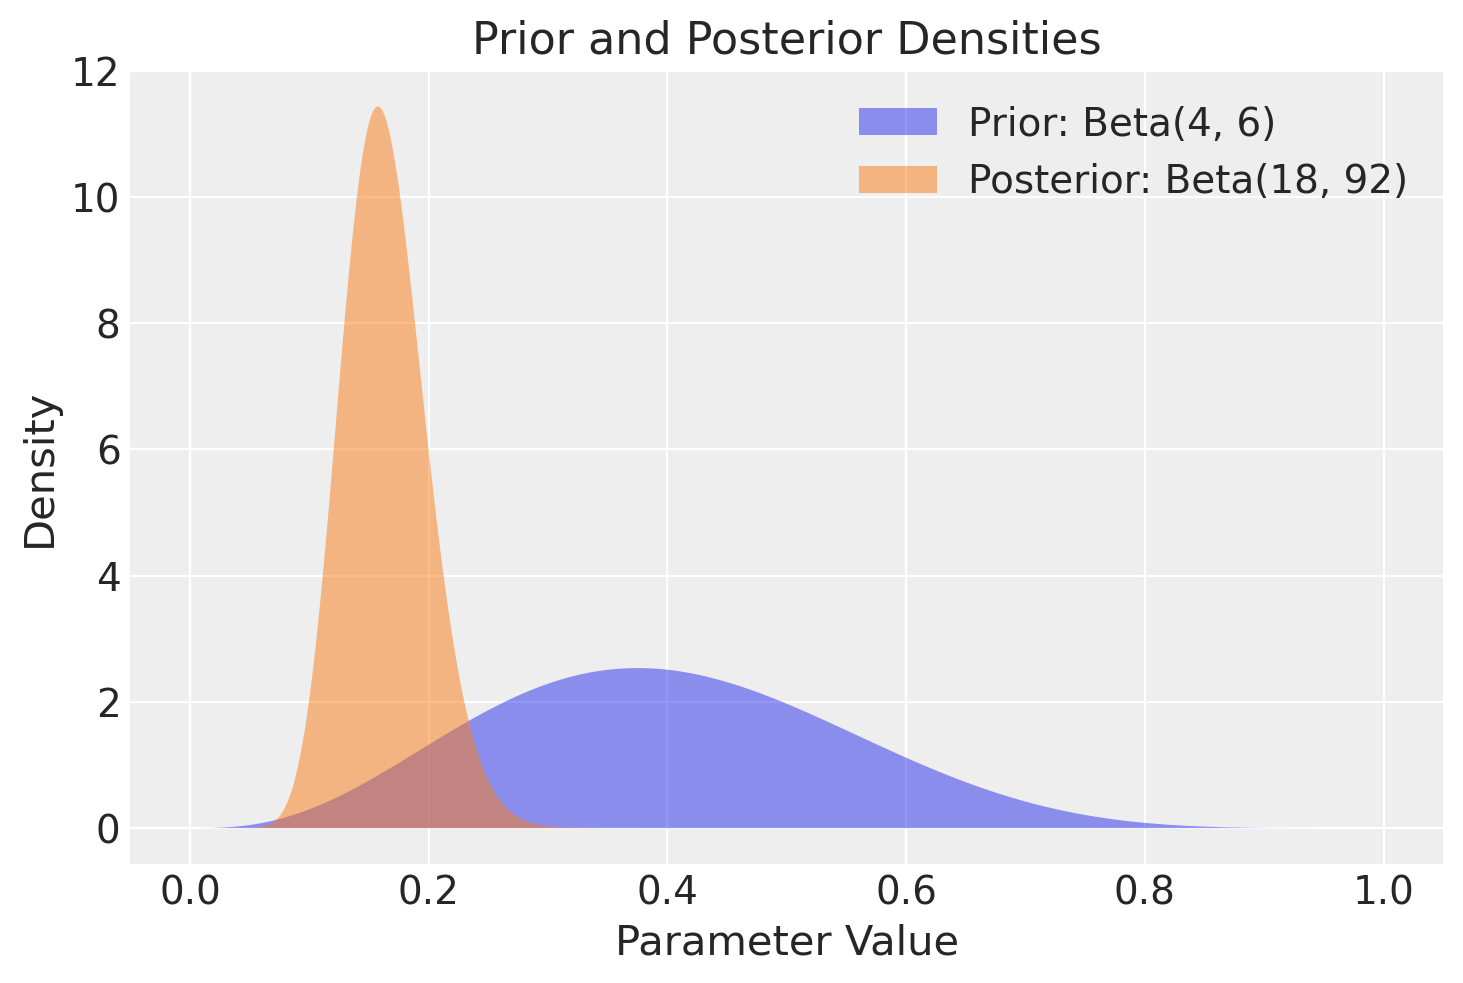

In [5]:
x = np.linspace(0, 1, 1000)

prior_density = stats.beta.pdf(x, 4, 6)
posterior_density = stats.beta.pdf(x, 18, 92)

plt.fill_between(x, prior_density, alpha=0.5, label="Prior: Beta(4, 6)")
plt.fill_between(x, posterior_density, alpha=0.5, label="Posterior: Beta(18, 92)")
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.legend()
plt.title("Prior and Posterior Densities")
plt.show()

Se vogliamo conoscere il valore della media a posteriori di $\theta$, il risultato esatto è

$$
\bar{\theta}_{post} = \frac{\alpha}{\alpha + \beta} = \frac{18}{18 + 92} \approx 0.1636.
$$

### Simulazione con distribuzione target nota

Usiamo ora una simulazione numerica per stimare la media a posteriori di $\theta$. Conoscendo la forma della distribuzione a posteriori $Beta(18, 92)$, possiamo generare un campione di osservazioni casuali da questa distribuzione. Successivamente, calcoliamo la media delle osservazioni ottenute per ottenere un'approssimazione della media a posteriori.

Se vogliamo ottenere un risultato approssimato con poche osservazioni (ad esempio, 10), possiamo procedere con la seguente simulazione:

In [6]:
y = stats.beta(18, 92).rvs(10)
print(y)

[0.18694021 0.12067309 0.17576971 0.1608302  0.12912987 0.20527983
 0.14209658 0.15057358 0.12001648 0.13024873]


In [7]:
np.mean(y)

0.1521558285153169

Tuttavia, con solo 10 campioni l'approssimazione potrebbe non essere molto accurata. Più aumentiamo il numero di campioni (cioè il numero di osservazioni casuali generate), più precisa sarà l'approssimazione. Aumentando il numero di campioni, ad esempio a 10000, otteniamo un risultato più preciso:

In [8]:
stats.beta(18, 92).rvs(10000).mean()

0.16380917953899665

Quando il numero di campioni a posteriori diventa molto grande, la distribuzione campionaria *converge* alla densità della popolazione. Questo concetto si applica non solo alla media, ma anche ad altre statistiche descrittive, come la moda e la varianza.

È importante sottolineare che l'applicazione della simulazione di Monte Carlo è efficace per calcolare distribuzioni a posteriori solo quando conosciamo la distribuzione stessa e possiamo utilizzare funzioni Python per estrarre campioni casuali da tale distribuzione. Ciò è stato possibile nel caso della distribuzione a posteriori $Beta(18, 92)$. 

Tuttavia, questa situazione ideale non si verifica sempre nella pratica, poiché le distribuzioni a priori coniugate alla verosimiglianza sono spesso rare. Per esempio, nel caso di una verosimiglianza binomiale e una distribuzione a priori gaussiana, l'espressione

$$
p(\theta \mid y) = \frac{\mathrm{e}^{-(\theta - 1 / 2)^2} \theta^y (1 - \theta)^{n - y}} {\int_0^1 \mathrm{e}^{-(t - 1 / 2)^2} t^y (1 - t)^{n - y} dt}
$$

rende impossibile calcolare analiticamente la distribuzione a posteriori di $\theta$, precludendo quindi l'utilizzo diretto di Python per generare campioni casuali.

In queste circostanze, però, è possibile ottenere campioni casuali dalla distribuzione a posteriori mediante l'uso di metodi Monte Carlo basati su Catena di Markov (MCMC). Gli algoritmi MCMC, come ad esempio l'algoritmo Metropolis, costituiscono una classe di metodi che consentono di estrarre campioni casuali dalla distribuzione a posteriori *senza richiedere la conoscenza della sua rappresentazione analitica*. Le tecniche MCMC sono ampiamente adottate per risolvere problemi di inferenza bayesiana e rappresentano il principale strumento computazionale per ottenere stime approssimate di distribuzioni a posteriori in situazioni complesse e non analiticamente trattabili.

## Algoritmo di Metropolis

L'algoritmo di Metropolis è un metodo avanzato per il campionamento da distribuzioni probabilistiche complesse. Appartiene alla famiglia dei metodi Monte Carlo Markov Chain (MCMC) e combina strategie di campionamento Monte Carlo con catene di Markov per navigare nello spazio dei parametri in modo intelligente. Questo consente di ottenere campioni rappresentativi della distribuzione di interesse indipendentemente dal punto di partenza, riducendo il rischio di bias nei risultati.

```code
ALGORITHM Metropolis(nsamp, xinit)
    // Initialize samples as an empty array of size nsamp
    x_prev = xinit

    FOR i = 0 TO nsamp - 1 DO
        x_star = GENERATE_NORMAL(mean = x_prev, std_dev = 0.1)
        
        IF 0 ≤ x_star ≤ 1 THEN
            p_star = POSTERIOR(x_star)
            p_prev = POSTERIOR(x_prev)
            
            IF p_prev > 0 THEN
                pdfratio = p_star / p_prev
            ELSE
                pdfratio = 1
            END IF
            
            random_chance = RANDOM_UNIFORM(0, 1)
            acceptance_probability = MIN(1, pdfratio)
            
            IF random_chance < acceptance_probability THEN
                samples[i] = x_star
                x_prev = x_star
            ELSE
                samples[i] = x_prev
            END IF
        ELSE
            samples[i] = x_prev
        END IF
    END FOR

    RETURN samples
END ALGORITHM

FUNCTION POSTERIOR(x)
    // This function should be defined elsewhere
    // It represents the product of the prior and likelihood
END FUNCTION
```

### Passaggi Fondamentali dell'Algoritmo di Metropolis

1. **Scegli un valore iniziale $\theta_1$. Imposta $t = 1$.**
2. **Campiona un possibile nuovo valore $\theta_p$ basato su una distribuzione di proposta $g(\theta_p \mid \theta_t)$**. Di solito, si usa una distribuzione normale $N(\theta_t, \tau)$ come distribuzione di proposta, dove $\tau$ funge da parametro di regolazione che controlla la dimensione del passo.
3. **Calcola il rapporto $\alpha = \frac{p(\theta_p \mid y)}{p(\theta_t \mid y)}$.**
4. **Se $\alpha \geq 1$, imposta $\theta_{t+1} = \theta_p$.**
5. **Se $\alpha < 1$, imposta $\theta_{t+1} = \theta_p$ con probabilità $\alpha$.** Altrimenti, imposta $\theta_{t+1} = \theta_t$.
6. **Ripeti dal passo 2 per campionare un nuovo valore $\theta_p$.**

### Dettagli dell'Algoritmo

- **Distribuzione di Proposta**: La distribuzione di proposta $g(\theta_p \mid \theta_t)$ è usata per generare nuovi campioni di $\theta_p$ basati sul valore corrente $\theta_t$. Una scelta comune è la distribuzione normale $N(\theta_t, \tau)$, dove $\tau$ è un parametro di tuning che controlla la dimensione dei passi del campionamento. Un valore di $\tau$ troppo grande o troppo piccolo può influenzare negativamente l'efficienza del campionamento.
  
- **Calcolo del Rapporto $\alpha$**: Il rapporto $\alpha$ è dato dalla probabilità a posteriori del nuovo valore $\theta_p$ rispetto alla probabilità a posteriori del valore corrente $\theta_t$. Questo rapporto determina l'accettazione o il rifiuto del nuovo campione.

- **Decisione di Accettazione**: 
  - Se $\alpha \geq 1$, il nuovo valore $\theta_p$ è sempre accettato.
  - Se $\alpha < 1$, il nuovo valore $\theta_p$ è accettato con probabilità $\alpha$. Se non viene accettato, il valore corrente $\theta_t$ è mantenuto per il prossimo passo.

Questo processo permette di esplorare lo spazio dei parametri $\theta$ generando una catena di Markov che, nel tempo, converge verso la distribuzione a posteriori $p(\theta \mid y)$. Utilizzando questa catena, possiamo stimare empiricamente le proprietà della distribuzione a posteriori.

La procedura continua con l'iterazione dei passi dal 2 al 5, permettendo alla catena di campioni di convergere alla distribuzione target. Inizialmente, i campioni potrebbero non essere rappresentativi, ma dopo un sufficiente numero di iterazioni (il cosiddetto "burn-in"), la distribuzione dei punti accettati dovrebbe avvicinarsi a quella che si intende esplorare.

L'efficienza di questo algoritmo deriva dalla sua abilità nel mantenere un equilibrio tra l'esplorazione di nuove possibilità e l'utilizzo di quelle già note. Questo viene realizzato attraverso l'adozione di un meccanismo che accetta i punti suggeriti in modo probabilistico, facilitando così la raccolta di un campione che riflette accuratamente la distribuzione di probabilità complessa sotto indagine.

Per una visualizzazione del comportamento dell'algoritmo di Metropolis nell'esplorare lo spazio dei parametri, si può consultare [questo post](https://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/). La distinzione tra i diversi metodi MCMC si basa principalmente sul tipo di distribuzione proposta e sul criterio di accettazione dei punti nel campionamento.

### Implementazione dell'Algoritmo di Metropolis

Iniziamo col definire la distribuzione a priori. In questo esempio, la distribuzione a priori è una distribuzione Beta(4, 6). 

In [14]:
def prior(p):
    alpha = 4
    beta = 6
    return stats.beta.pdf(p, alpha, beta)

Definiamo la verosimiglianza. Il problema presente richiede una verosimiglianza binomiale.

In [15]:
def likelihood(p):
    y = 14
    n = 100
    return stats.binom.pmf(y, n, p)

La distribuzione a posteriori non normalizzata è il prodotto della distribuzione a priori e della verosimiglianza. Si noti che, per il motivo spiegato prima, non è necessario normalizzare la distribuzione a posteriori.

In [16]:
def posterior(p):
    return likelihood(p) * prior(p)

Nell'implementazione di un algoritmo di Metropolis in ambito bayesiano, vi sono diversi aspetti da considerare attentamente. Ecco alcuni punti cruciali:

1. **Simmetria della Distribuzione Proposta**: È fondamentale che la distribuzione proposta sia simmetrica. Questa è una condizione necessaria per il funzionamento dell'algoritmo di Metropolis, ma non per quello di Metropolis-Hastings.
  
2. **Valore Iniziale**: Il valore iniziale scelto dovrebbe essere plausibile in base alla distribuzione a priori, in modo da facilitare la convergenza dell'algoritmo.

3. **Probabilità Zero**: Nel caso in cui la verosimiglianza o il prior assumano un valore di zero, il rapporto tra le densità di probabilità (`pdfratio`) all'interno dell'algoritmo di Metropolis risulterà indefinito. Pertanto, è importante garantire che il valore `x_star`, generato dalla distribuzione proposta, cada sempre entro i limiti del supporto sia del prior che della verosimiglianza.

Di seguito è presentato il codice dell'algoritmo di Metropolis.

In [17]:
# Definizione della funzione dell'algoritmo di Metropolis.
# nsamp: Numero di campioni da generare.
# xinit: Valore iniziale da cui iniziare il sampling.
def metropolis(nsamp, xinit):
    # Inizializza un array vuoto per conservare i campioni generati.
    samples = np.empty(nsamp)

    # Imposta il primo valore (valore iniziale) da cui partire per la generazione dei campioni.
    x_prev = xinit

    # Inizia un ciclo che si ripeterà per il numero di volte specificato da nsamp (numero di campioni da generare).
    for i in range(nsamp):
        # Genera un nuovo punto (x_star) usando una distribuzione normale (gaussiana).
        # Questo nuovo punto è generato in modo da essere "vicino" al punto precedente (x_prev),
        # con una deviazione standard di 0.1. Questo significa che la maggior parte dei punti
        # sarà entro 0.1 unità da x_prev, ma alcuni potrebbero essere più lontani.
        x_star = np.random.normal(x_prev, 0.1)

        # Verifica che il nuovo punto (x_star) sia un valore plausibile nel contesto del problema.
        # Qui, l'assunzione è che x_star debba essere tra 0 e 1. Se non lo è, il punto è rifiutato.
        if 0 <= x_star <= 1:
            # Calcola il valore della funzione di densità di probabilità posterior per il nuovo punto e il punto precedente.
            # La funzione posterior è definita altrove e rappresenta il prodotto del prior e della likelihood.
            p_star = posterior(x_star)
            p_prev = posterior(x_prev)

            # Calcola il rapporto tra le densità posterior del nuovo punto e del punto precedente.
            # Questo rapporto determina la probabilità di accettare il nuovo punto.
            # Se p_prev è 0, per evitare la divisione per zero, il rapporto è impostato a 1.
            pdfratio = p_star / p_prev if p_prev > 0 else 1

            # Genera un numero casuale tra 0 e 1.
            random_chance = np.random.uniform()

            # Calcola il rapporto tra la densità posteriore del nuovo punto e quella del punto precedente.
            # Se il nuovo punto è migliore o uguale, questo rapporto sarà >= 1.
            # Se il nuovo punto è peggiore, il rapporto sarà un numero fra 0 e 1.
            acceptance_probability = min(1, pdfratio)

            # Se il numero casuale è minore dell'acceptance_probability, accettiamo il nuovo punto.
            # Ciò significa che un punto migliore o uguale viene sempre accettato (perché random_chance sarà sempre < 1),
            # mentre un punto peggiore ha una possibilità basata sul quanto è peggiore.
            if random_chance < acceptance_probability:
                samples[i] = x_star  # Accetta il nuovo punto.
                x_prev = (
                    x_star  # Aggiorna il punto precedente con il nuovo punto accettato.
                )
            else:
                samples[i] = (
                    x_prev  # Mantiene il punto precedente se il nuovo punto non è accettato.
                )
        else:
            samples[i] = (
                x_prev  # Se x_star non è nel supporto, conserva il punto precedente.
            )

    # Dopo aver generato il numero desiderato di campioni, ritorna l'array dei campioni.
    return samples

L'idea fondamentale dietro la fase dell'algoritmo di Metropolis successiva al calcolo di `p_star` e `p_prev` è decidere se "muoversi" verso un nuovo punto basandosi su quanto è probabile (o "buono") quel punto rispetto al punto attuale, in termini della densità posteriore. Qui, la "probabilità" di un punto è data dalla sua densità posteriore, che è un modo per misurare quanto bene un certo valore del parametro si adatta ai dati osservati, dato un modello.

Ecco come funziona:

1. **Generazione di un numero casuale**.

2. **Confronto tra i punti**: Si confronta il "valore" del nuovo punto (`x_star`) con quello del punto precedente (`x_prev`). Questo "valore" è dato dalla densità posteriore: più alto è, meglio è.

3. **Decisione**:
   - Se il nuovo punto è **migliore** del precedente (ovvero, ha una densità posteriore **maggiore o uguale**), lo accettiamo sempre. 
   - Se il nuovo punto è **peggiore** del precedente (ha una densità posteriore **minore**), non lo rifiutiamo subito. Invece, gli diamo una chance di essere scelto, ma questa chance è più piccola quanto più il nuovo punto è "peggiore". 

In termini di codice, questa logica si traduce così:

```python
# Genera un numero casuale tra 0 e 1.
random_chance = np.random.uniform()

# Calcola il rapporto tra la densità posteriore del nuovo punto e quella del punto precedente.
# Se il nuovo punto è migliore o uguale, questo rapporto sarà >= 1.
# Se il nuovo punto è peggiore, il rapporto sarà un numero fra 0 e 1.
acceptance_probability = min(1, pdfratio)

# Se il numero casuale è minore dell'acceptance_probability, accettiamo il nuovo punto.
# Ciò significa che un punto migliore o uguale viene sempre accettato (perché random_chance sarà sempre < 1),
# mentre un punto peggiore ha una possibilità basata sul quanto è peggiore.
if random_chance < acceptance_probability:
    samples[i] = x_star  # Accetta il nuovo punto.
    x_prev = x_star      # Aggiorna il punto precedente con il nuovo punto accettato.
else:
    samples[i] = x_prev  # Mantiene il punto precedente se il nuovo punto non è accettato.
```

In sintesi, questo meccanismo consente all'algoritmo di esplorare lo spazio dei parametri in modo efficiente, accettando sempre miglioramenti e, occasionalmente, facendo passi in direzioni non ottimali per evitare di rimanere intrappolati in "minimi locali", ovvero in soluzioni che sembrano buone rispetto a quelle vicine ma non sono le migliori globalmente. 

Si osservi un punto importante: nel calcolo di `pdfratio`, il rapporto tra la densità a posteriori del parametro proposto `x_star` e quella del parametro corrente `x_prev`, la costante di normalizzazione si annulla grazie alla regola di Bayes. Questo lascia nel rapporto solamente le componenti relative alla verosimiglianza e alla distribuzione a priori, che sono entrambe facilmente calcolabili. Matematicamente, questo si esprime come:

$$
\begin{equation}
\text{pdfratio} = \frac{p(\theta^* \mid y)}{p(\theta^{\text{prev}} \mid y)} = \frac{\frac{p(y \mid \theta^*) p(\theta^*)}{p(y)}}{\frac{p(y \mid \theta^{\text{prev}}) p(\theta^{\text{prev}})}{p(y)}}
= \frac{p(y \mid \theta^*) p(\theta^*)}{p(y \mid \theta^{\text{prev}}) p(\theta^{\text{prev}})}
\end{equation}
$$ (eq-ratio-metropolis)

Eseguiamo dunque il campionamento usando l'algoritmo che abbiamo definito.

In [18]:
n_samples = 100_000
samps = metropolis(n_samples, 0.5)

In somma, l'algoritmo Metropolis accetta come input il numero `nsamp` di passi da simulare e il punto di partenza. Come output, l'algoritmo restituisce una catena di valori del parametro, specificamente la sequenza $\theta^{(1)}, \theta^{(2)}, \ldots, \theta^{\text{nsamp}}$. Uno degli aspetti cruciali per la riuscita dell'algoritmo è il raggiungimento della stazionarietà da parte della catena. In genere, i primi 1000-5000 valori vengono scartati in quanto rappresentano il periodo di "burn-in" della catena. Dopo un determinato numero di passi $k$, la catena converge e i valori diventano campioni effettivi dalla distribuzione a posteriori $p(\theta \mid y)$.

Il modello descritto è stato inizialmente proposto da Metropolis et al. nel 1953 [@metropolist_etal_1953]. Hastings nel 1970 introdusse un'estensione nota come algoritmo Metropolis-Hastings [@hastings_1970]. Altre varianti includono il campionatore di Gibbs, introdotto da Geman e Geman nel 1984 [@geman_geman_1984], l'Hamiltonian Monte Carlo [@duane1987hybrid], e il No-U-Turn Sampler (NUTS) utilizzato in pacchetti come PyMC e Stan [@hoffman2014no]. Per un'analisi più dettagliata e intuitiva dell'algoritmo Metropolis, si rimanda a @doingbayesian.

Un elemento chiave da considerare nell'uso dell'algoritmo Metropolis è il tasso di accettazione, che è il rapporto tra il numero di valori del parametro proposti e il numero di quei valori che vengono effettivamente accettati. Un limite di questo algoritmo è la sua inefficienza relativa: rispetto alle sue varianti più moderne, l'algoritmo Metropolis tende ad essere meno efficiente.

## Aspetti computazionali

### Warm-up/Burn-in

Una catena di Markov ha bisogno di alcune iterazioni per raggiungere la distribuzione stazionaria. Queste iterazioni sono comunemente chiamate iterazioni di warm-up o burn-in (a seconda dell'algoritmo e del software utilizzato) e vengono di solito scartate. In molti programmi software, la prima metà delle iterazioni viene considerata come iterazioni di warm-up, quindi, nel caso presente, anche se abbiamo ottenuto 100000 iterazioni, ne utilizzeremo solo 50000.

### Sintesi della distribuzione a posteriori

L'array `samps` contiene 100000 valori di una catena di Markov. Escludiamo i primi 50000 valori considerati come burn-in e consideriamo i restanti 50000 valori come un campione casuale estratto dalla distribuzione a posteriori $p(\theta \mid y)$.

Mediante i valori della catena così ottenuta è facile trovare una stima a posteriori del parametro $\theta$. Per esempio, possiamo trovare la stima della media a posteriori.

In [19]:
burnin = int(n_samples * 0.5)
burnin

50000

In [20]:
np.mean(samps[burnin:])

0.16408968344081415

Oppure possiamo stimare la deviazione standard della distribuzione a posteriori.

In [21]:
np.std(samps[burnin:])

0.03513787973422409

Visualizziamo un *trace plot* dei valori della catena di Markov dopo il periodo di burn-in.

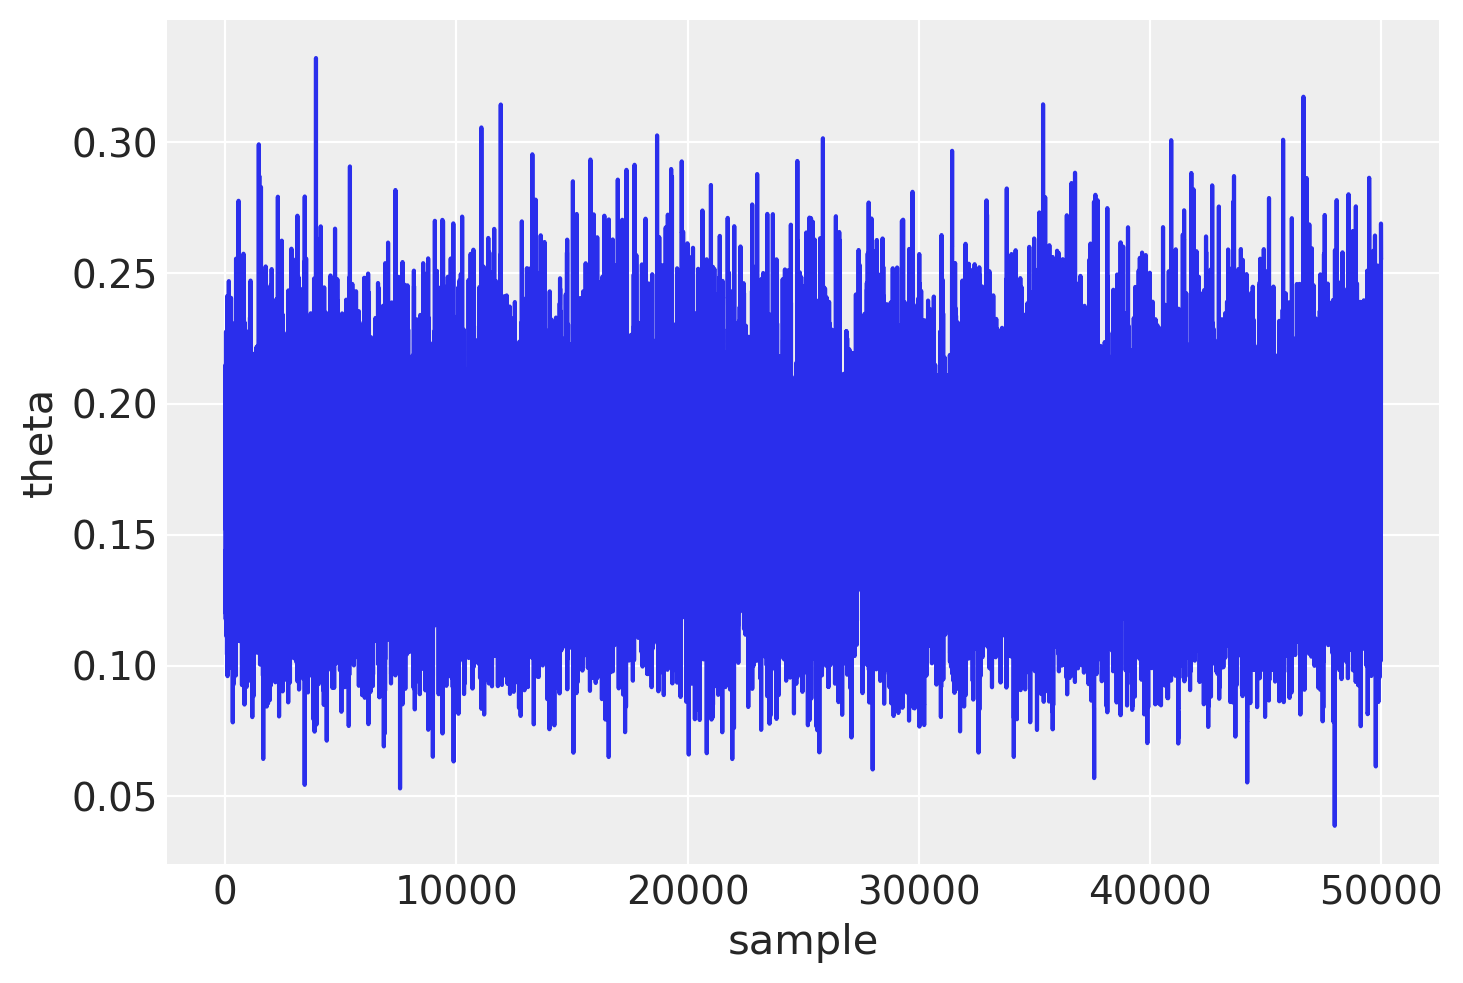

In [22]:
plt.plot(samps[burnin:])
plt.xlabel("sample")
plt.ylabel("theta")
plt.show()

Il trace plot indica che la catena inizia con un valore casuale per poi spostarsi rapidamente nell'area intorno a 0.16, che è l'area con alta densità a posteriori. Successivamente, oscilla intorno a quel valore per le iterazioni successive.

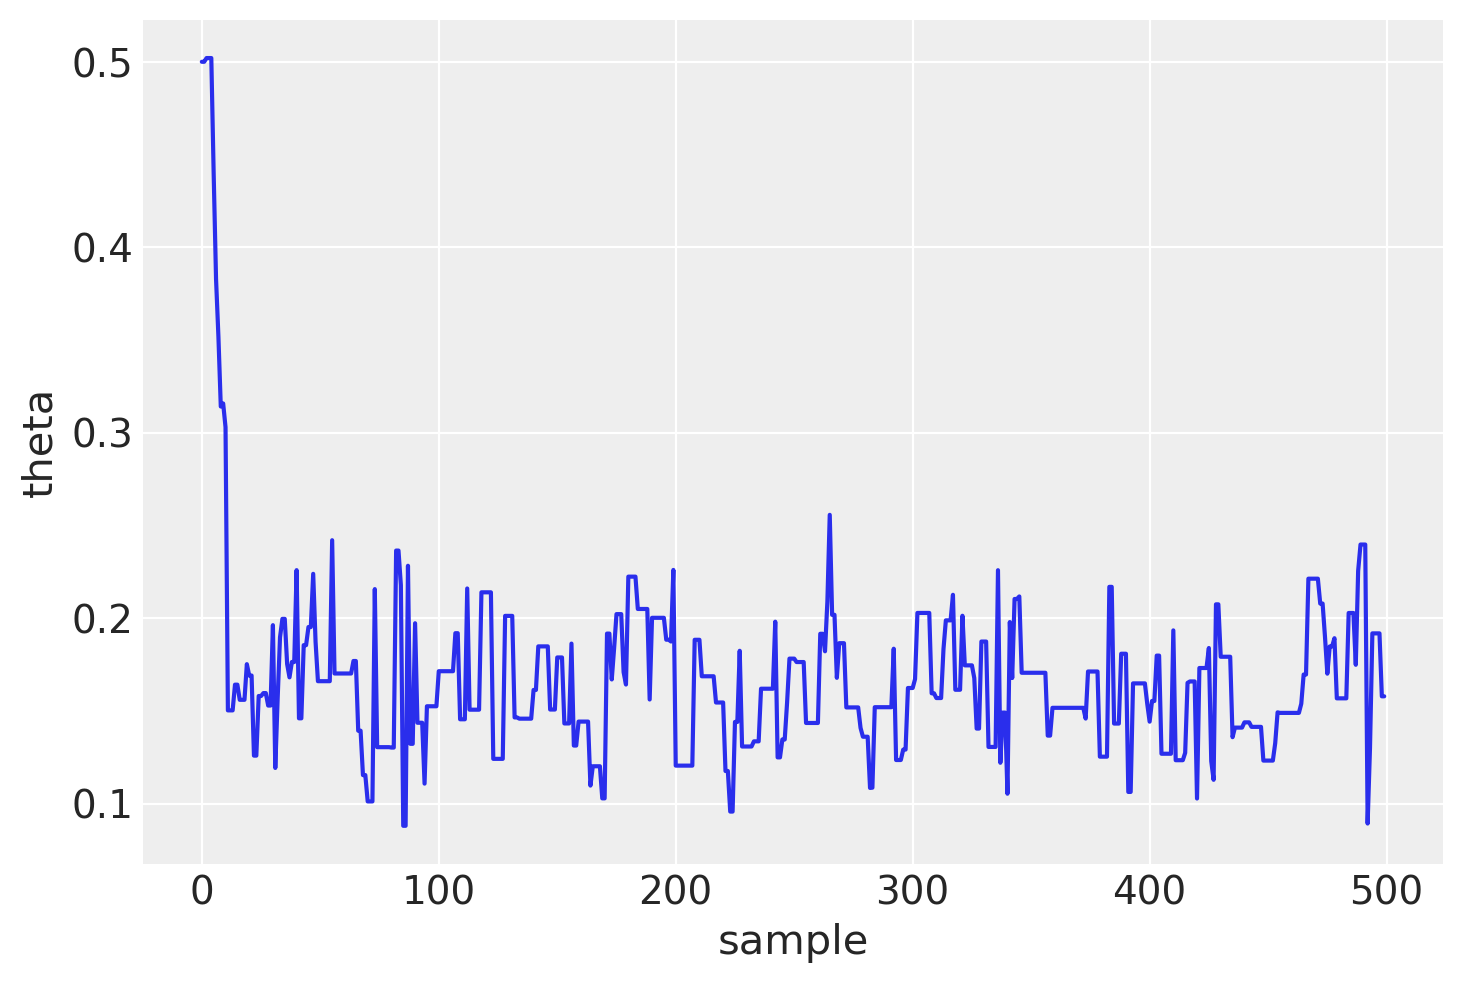

In [23]:
plt.plot(samps[:500])
plt.xlabel("sample")
plt.ylabel("theta")
plt.show()

L'istogramma mostrato di seguito, sul quale è stata sovrapposta la distribuzione a posteriori derivata analiticamente -- specificamente una $\text{Beta}(25, 17)$ -- dimostra che la catena converge effettivamente alla distribuzione a posteriori desiderata.

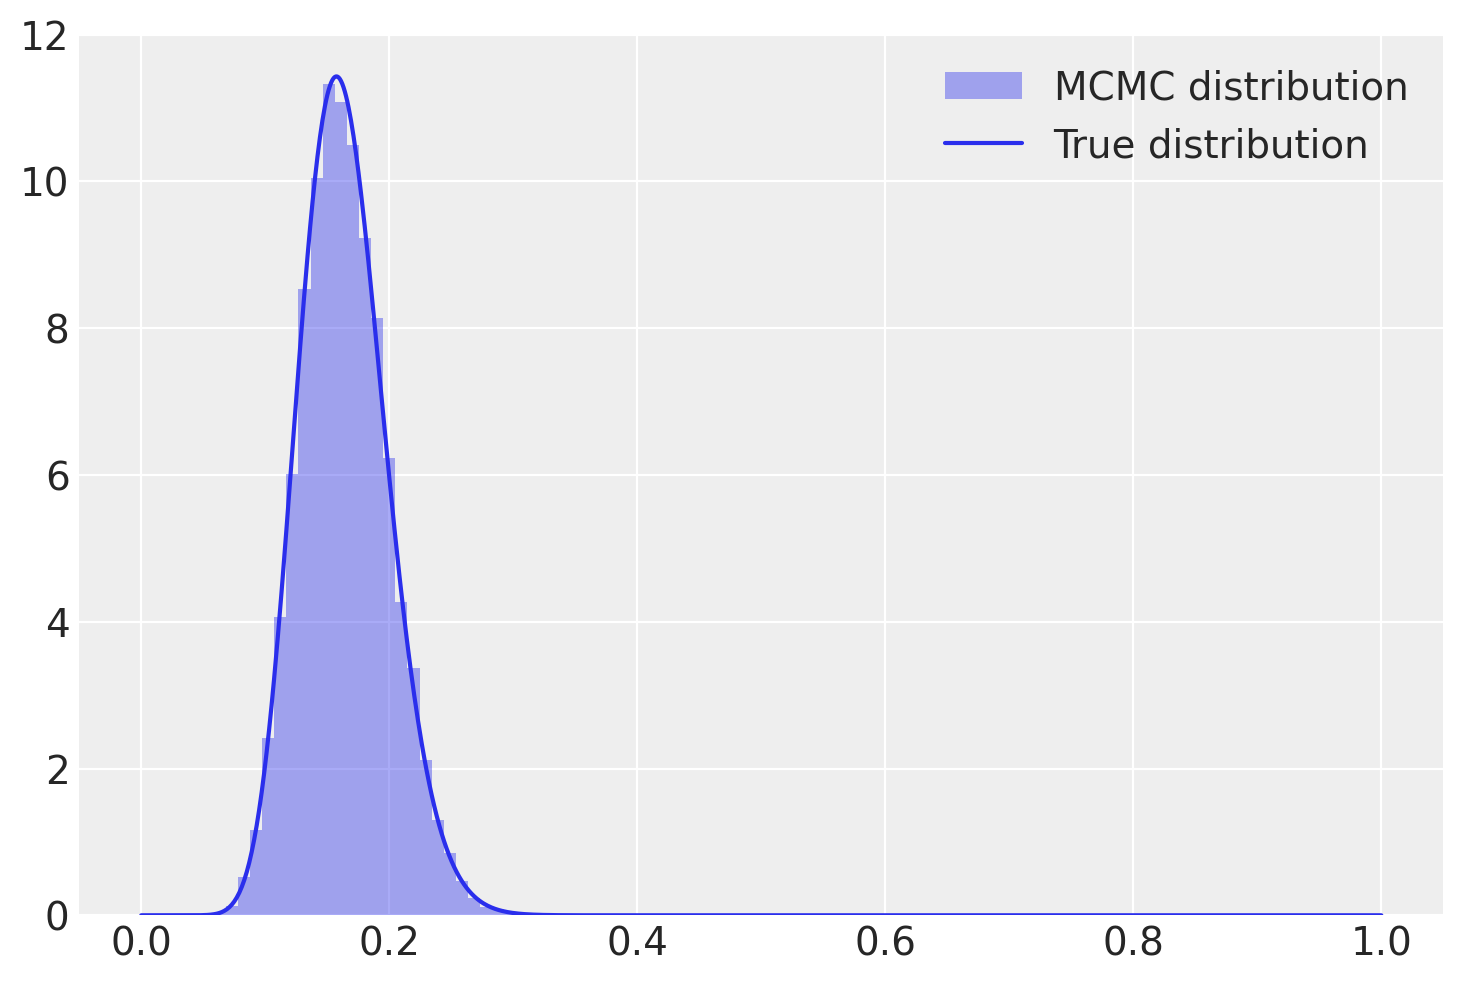

In [24]:
plt.hist(samps[burnin:], bins=30, alpha=0.4, label="MCMC distribution", density=True)
# plot the true function
x = np.linspace(0, 1, 1000)
plt.plot(x, stats.beta.pdf(x, 18, 92), "C0", label="True distribution")
plt.legend()
plt.show()

È possibile usare la funzione `summary` del pacchetto AriviZ per calolare l'intervallo di credibilità, ovvero l'intervallo che contiene la proporzione indicata dei valori estratti a caso dalla distribuzione a posteriori.

In [25]:
az.summary(samps[burnin:], kind="stats", hdi_prob=0.94, round_to=2)

,mean,sd,hdi_3%,hdi_97%
x,0.16,0.04,0.1,0.23


Un KDE plot corrispondente all'istogramma precedente si può generare usando `az.plot_posterior()`. La curva  rappresenta l'intera distribuzione a posteriori e viene calcolata utilizzando la stima della densità del kernel (KDE) che serve a "lisciare" l'istogramma.

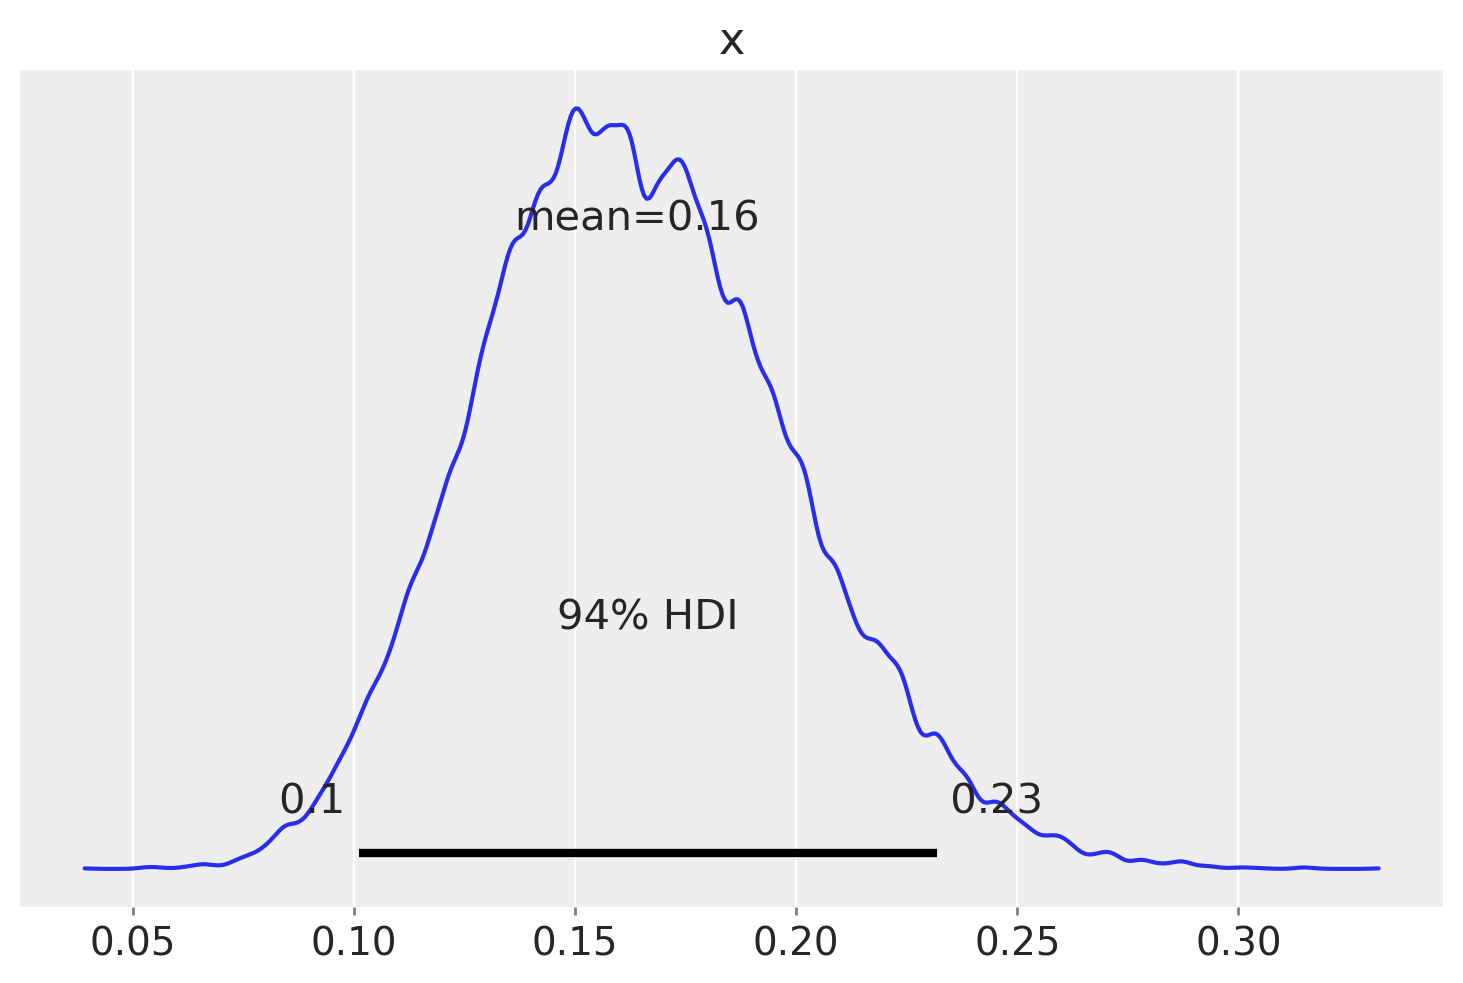

In [26]:
az.plot_posterior(samps[burnin:])
plt.show()

L'HDI è una scelta comune nelle statistiche bayesiane e valori arrotondati come 50% o 95% sono molto popolari. Ma ArviZ utilizza il 94% come valore predefinito. La ragione di questa scelta è che il 94% è vicino al valore ampiamente utilizzato del 95%, ma è anche diverso da questo, così da servire da "amichevole promemoria" che non c'è niente di speciale nella soglia del 5%. Idealmente sarebbe opportuno scegliere un valore che si adatti alle specifiche esigenze dell'analisi statistica che si sta svolgendo, o almeno riconoscere che si sta usando un valore arbitrario.

## Diagnostiche della soluzione MCMC

### Catene multiple

Poiché ciascuno stato in una catena di Markov dipende dagli stati precedenti, il valore o i valori iniziali possono influenzare i valori campionati. Una soluzione per verificare la sensibilità rispetto ai valori iniziali è utilizzare più catene, ognuna con diversi valori iniziali. Se più catene campionano la stessa distribuzione target, queste dovrebbero mescolarsi bene, ovvero intersecarsi l'una con l'altra in un trace plot.

### Stazionarietà

Un punto importante da verificare è se il campionatore ha raggiunto la sua distribuzione stazionaria. La convergenza di una catena di Markov alla distribuzione stazionaria viene detta "mixing".

### Autocorrelazione

Ogni passo nell'algoritmo MCMC è chiamato *iterazione*. I valori campionati sono dipendenti, il che significa che il valore all'iterazione $m$ dipende dal valore all'iterazione $m-1$. Questa è una differenza importante rispetto alle funzioni che generano campioni casuali indipendenti, come `beta(25, 17).rvs()`. I valori campionati formano una *catena di Markov*, il che significa che ciascun valore campionato è correlato con il valore precedente (ad esempio, se $\theta(m)$ è grande, $\theta(m+1)$ sarà anch'esso grande).

Informazioni sul "mixing" della catena di Markov sono fornite dall'autocorrelazione. L'autocorrelazione misura la correlazione tra i valori successivi di una catena di Markov. Il valore $m$-esimo della serie ordinata viene confrontato con un altro valore ritardato di una quantità $k$ (dove $k$ è l'entità del ritardo) per verificare quanto si correli al variare di $k$. L'autocorrelazione di ordine 1 (*lag 1*) misura la correlazione tra valori successivi della catena di Markow (cioè, la correlazione tra $\theta^{(m)}$ e $\theta^{(m-1)}$); l'autocorrelazione di ordine 2 (*lag 2*) misura la correlazione tra valori della catena di Markow separati da due "passi" (cioè, la correlazione tra $\theta^{(m)}$ e $\theta^{(m-2)}$); e così via.

L'autocorrelazione di ordine $k$ è data da $\rho_k$ e può essere stimata come:

$$
\begin{align}
\rho_k &= \frac{Cov(\theta_m, \theta_{m+k})}{Var(\theta_m)}\notag\\
&= \frac{\sum_{m=1}^{n-k}(\theta_m - \bar{\theta})(\theta_{m-k} - \bar{\theta})}{\sum_{m=1}^{n-k}(\theta_m - \bar{\theta})^2} \qquad\text{con }\quad \bar{\theta} = \frac{1}{n}\sum_{m=1}^{n}\theta_m.
\end{align}
$$ (eq-autocor)

Per fare un esempio pratico, simuliamo dei dati autocorrelati.

In [40]:
x = pd.array([22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51])
print(x)

<IntegerArray>
[22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51]
Length: 15, dtype: Int64


L'autocorrelazione di ordine 1 è semplicemente la correlazione tra ciascun elemento e quello successivo nella sequenza.

In [41]:
sm.tsa.acf(x)

array([ 1.        ,  0.83174224,  0.65632458,  0.49105012,  0.27863962,
        0.03102625, -0.16527446, -0.30369928, -0.40095465, -0.45823389,
       -0.45047733, -0.36933174])

Nell'esempio, il vettore `x` è una sequenza temporale di 15 elementi. Il vettore $x'$ include gli elementi con gli indici da 0 a 13 nella sequenza originaria, mentre il vettore $x''$ include gli elementi 1:14. Gli elementi delle coppie ordinate dei due vettori avranno dunque gli indici $(0, 1)$, $(1, 2), (2, 3), \dots (13, 14)$ degli elementi della sequenza originaria. La correlazione di Pearson tra i vettori $x'$ e $x''$ corrisponde all'autocorrelazione di ordine 1 della serie temporale.

Nell'output precedente

-   0.83174224 è l'autocorrelazione di ordine 1 (lag = 1),
-   0.65632458 è l'autocorrelazione di ordine 2 (lag = 2),
-   0.49105012 è l'autocorrelazione di ordine 3 (lag = 3),
-   ecc.

È possibile specificare il numero di ritardi (*lag*) da utilizzare con l'argomento `nlags`:

In [42]:
sm.tsa.acf(x, nlags=4)

array([1.        , 0.83174224, 0.65632458, 0.49105012, 0.27863962])

In Python possiamo creare un grafico della funzione di autocorrelazione (correlogramma) per una serie temporale usando la funzione `tsaplots.plot_acf()` dalla libreria `statsmodels`.

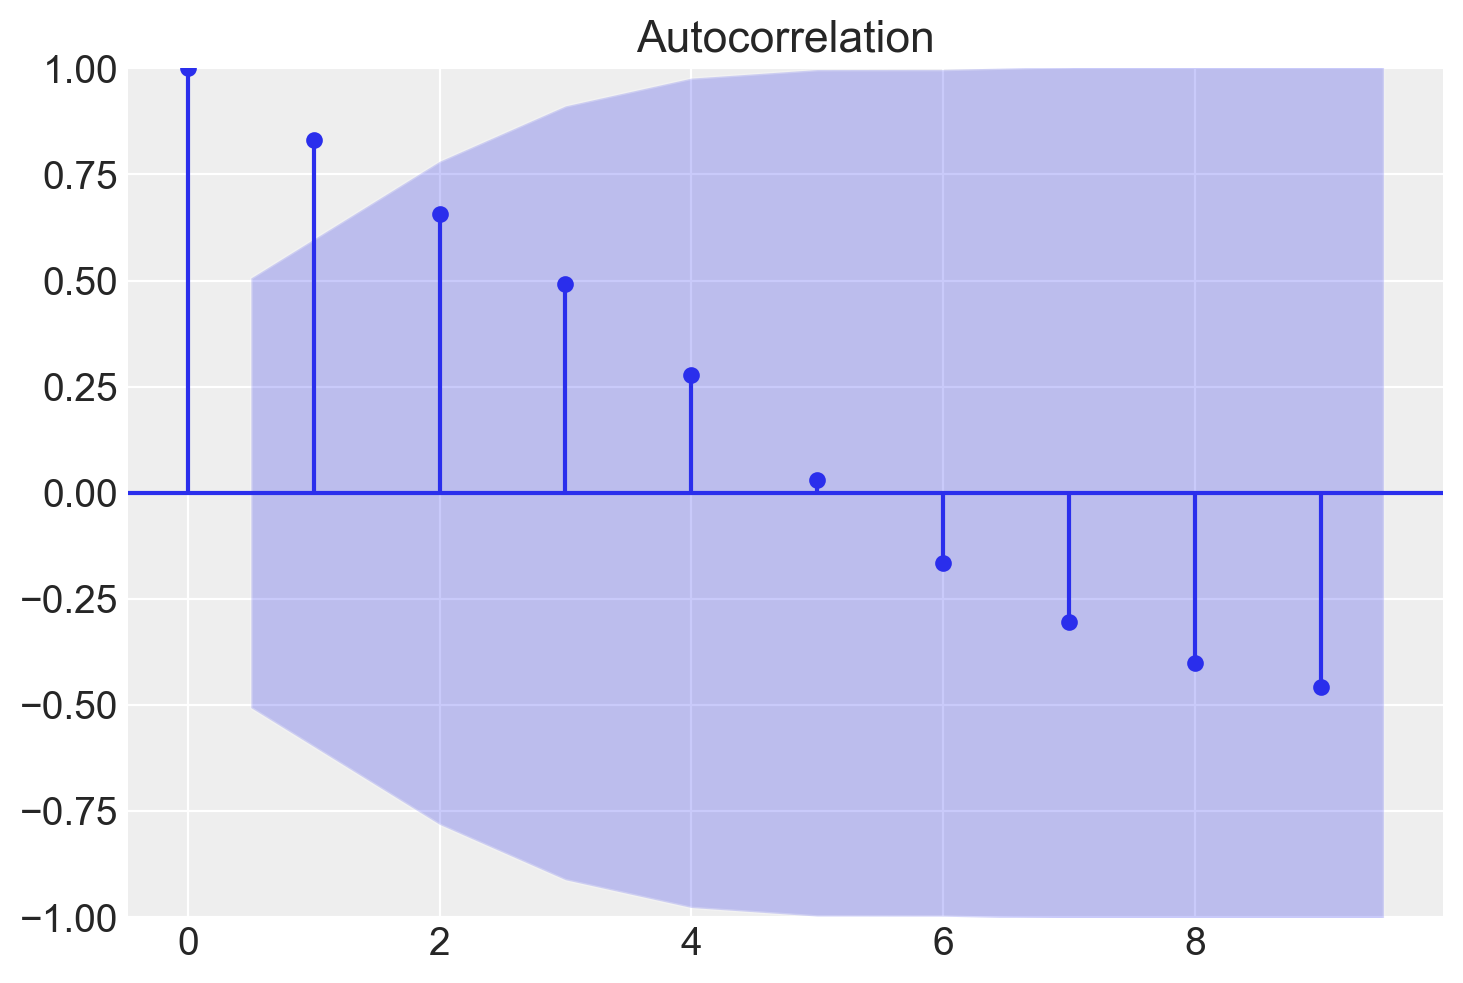

In [43]:
tsaplots.plot_acf(x, lags=9)
plt.show()

Per i dati dell'esempio in discussione otteniamo la situazione seguente.

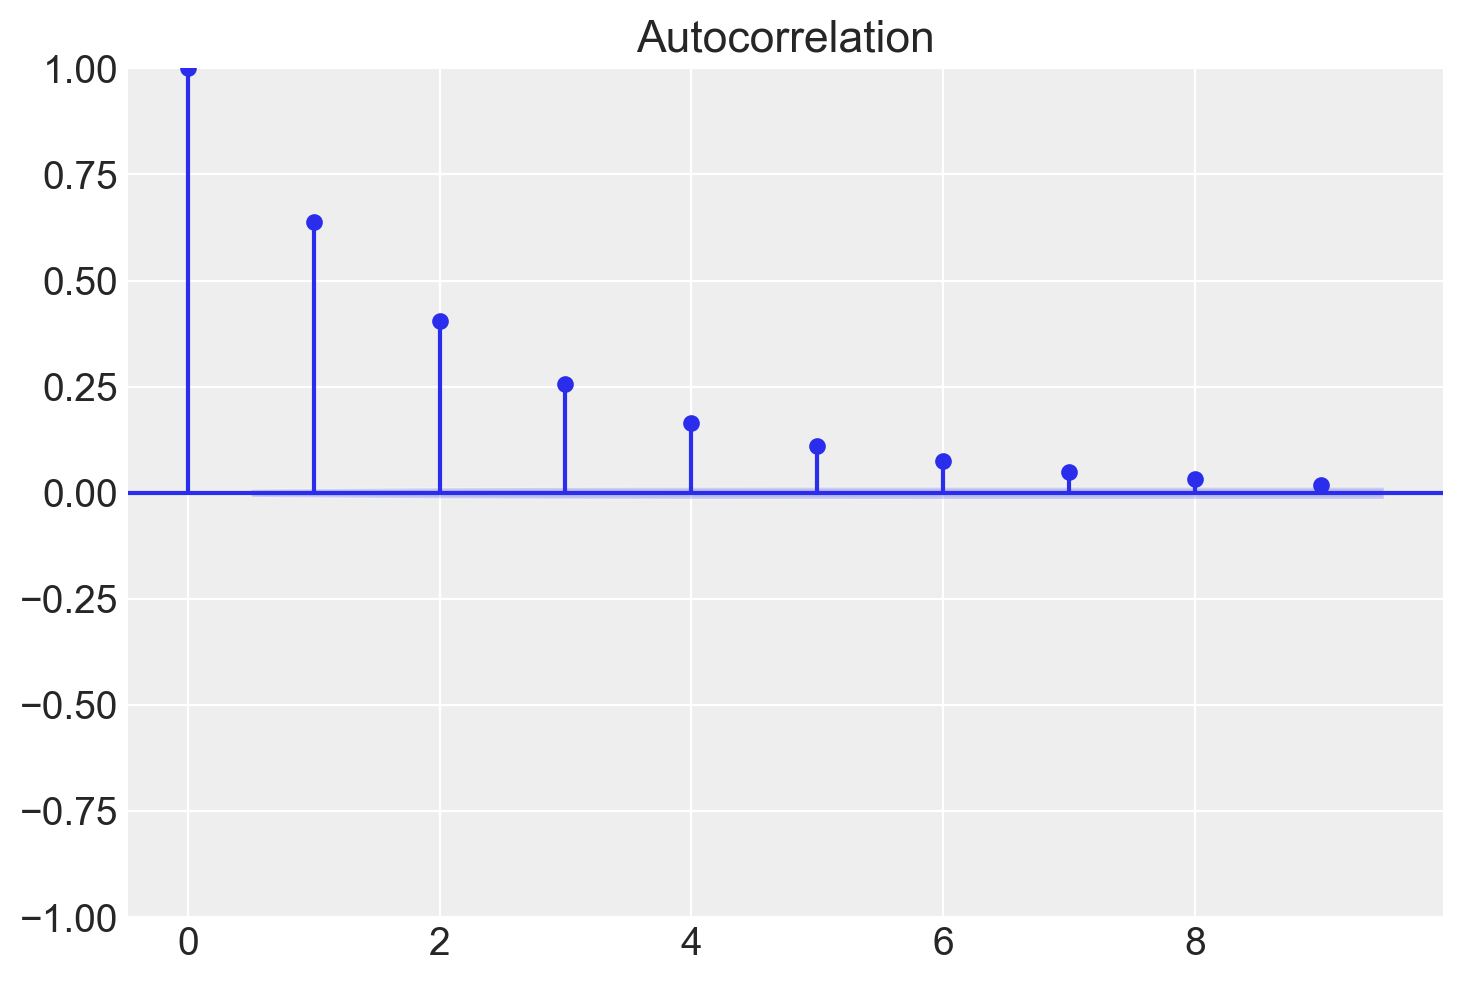

In [44]:
tsaplots.plot_acf(samps[burnin:], lags=9)
plt.show()

Il correlogramma è uno strumento grafico usato per la valutazione della tendenza di una catena di Markov nel tempo. Il correlogramma si costruisce a partire dall'autocorrelazione $\rho_k$ di una catena di Markov in funzione del ritardo $k$ con cui l'autocorrelazione è calcolata: nel grafico ogni barretta verticale riporta il valore dell'autocorrelazione (sull'asse delle ordinate) in funzione del ritardo (sull'asse delle ascisse).

In situazioni ottimali l'autocorrelazione diminuisce rapidamente ed è effettivamente pari a 0 per piccoli lag. Ciò indica che i valori della catena di Markov che si trovano a più di soli pochi passi di distanza gli uni dagli altri non risultano associati tra loro, il che fornisce una conferma del "mixing" della catena di Markov, ossia della convergenza alla distribuzione stazionaria. Nelle analisi bayesiane, una delle strategie che consentono di ridurre l'autocorrelazione è quella di assottigliare l'output immagazzinando solo ogni $m$-esimo punto dopo il periodo di burn-in. Una tale strategia va sotto il nome di *thinning*.

Nel seguente correlogramma, analizziamo la medesima catena di Markov. Tuttavia, in questa occasione applichiamo un "thinning" (sottocampionamento) con un fattore di 5.

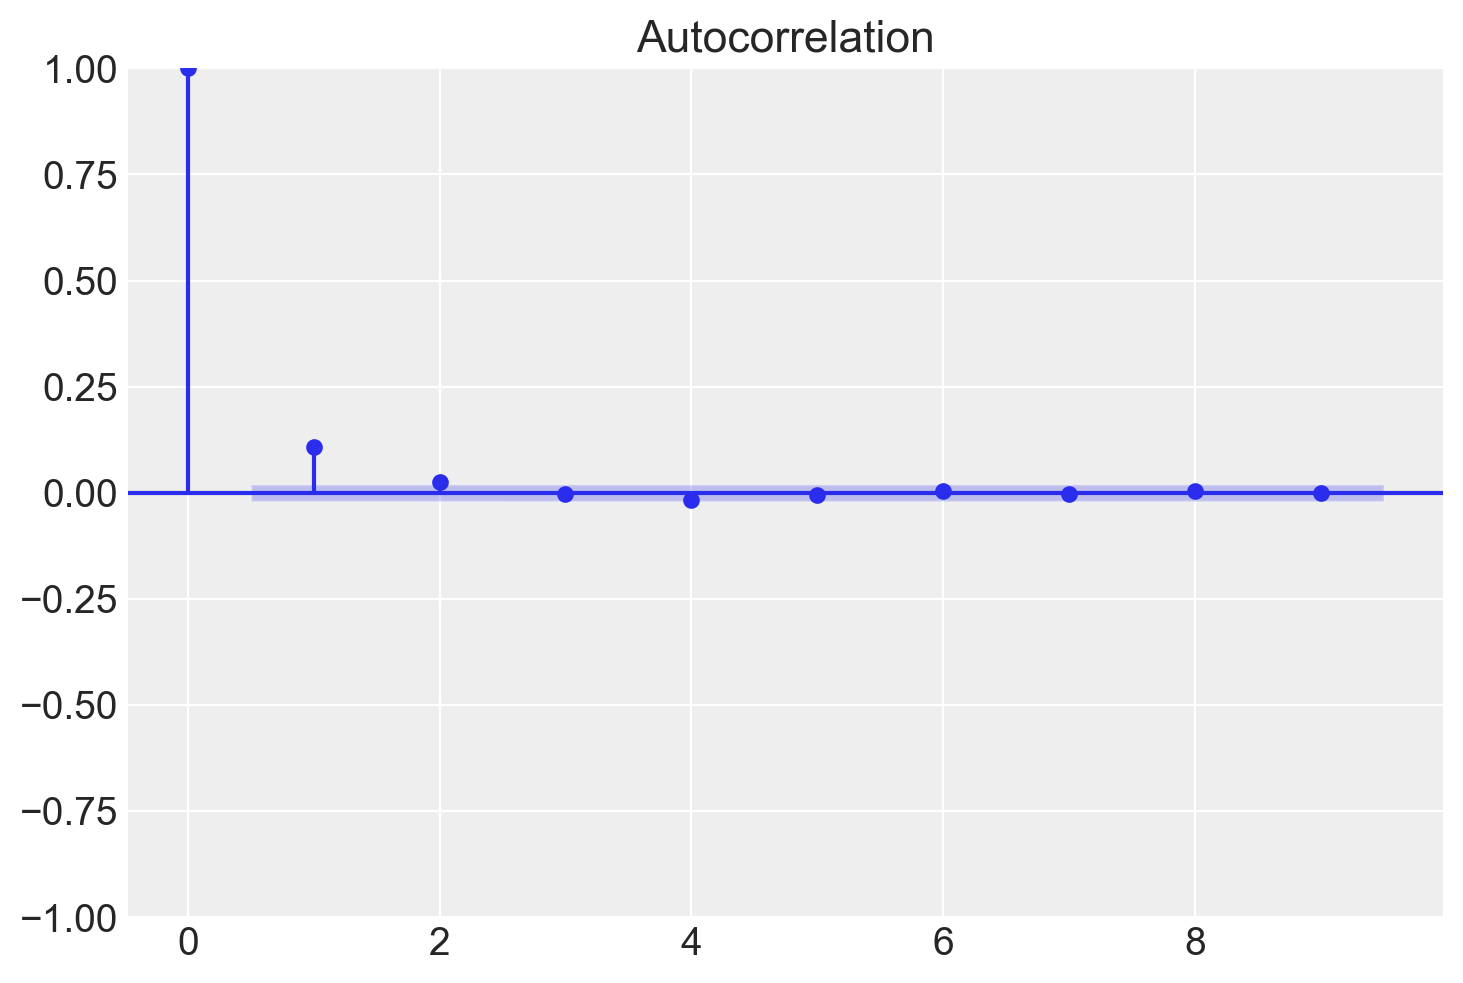

In [45]:
thin = 5
sampsthin = samps[burnin::thin]
tsaplots.plot_acf(sampsthin, lags=9)
plt.show()

Si può notare come l'autocorrelazione diminuisce molto più rapidamente.

#### Tasso di accettazione

Quando si utilizza l'algoritmo Metropolis, è importante monitorare il tasso di accettazione e assicurarsi che sia nell'intervallo ottimale. Se si accetta quasi sempre il candidato proposto, probabilmente significa che, in ogni iterazione, la catena salta solo di un piccolo passo (in modo che il rapporto di accettazione sia vicino a 1 ogni volta). Di conseguenza, la catena impiegherà molte iterazioni per raggiungere altre regioni della distribuzione stazionaria e i campioni consecutivi saranno molto fortemente correlati. D'altra parte, se il tasso di accettazione è molto basso, la catena rimarrà bloccata nella stessa posizione per molte iterazioni prima di spostarsi verso uno stato diverso. Per l'algoritmo Metropolis base con un singolo parametro con una distribuzione proposta Gaussiana normale, un tasso di accettazione ottimale è compreso tra il 40% e il 50%.

#### Test di convergenza

Per valutare la convergenza di una catena di Markov Monte Carlo (MCMC), esistono diversi metodi, tra cui approcci grafici e test statistici. Ecco una spiegazione più chiara e dettagliata:

### Approcci Grafici: Tracce delle Serie Temporali (Trace Plots)

Le tracce delle serie temporali, o trace plots, sono grafici che mostrano l'evoluzione dei valori campionati rispetto al numero di iterazioni. Questi grafici sono utili per valutare visivamente se la catena ha raggiunto la convergenza. Segni che indicano una potenziale convergenza includono:

- **Assenza di Tendenze**: Non ci sono trend ascendenti o discendenti nel corso delle iterazioni.
- **Costanza dell'Ampiezza**: La variabilità dei valori campionati rimane costante nel tempo, senza significative fluttuazioni.
- **Mancanza di Periodicità**: Non si osservano cicli o ripetizioni regolari che potrebbero indicare la presenza di correlazioni residue.

### Test Statistici per la Convergenza

Oltre agli approcci grafici, esistono test statistici specifici che possono aiutare a determinare se la catena ha raggiunto uno stato stazionario.

#### Test di Geweke

Il test di Geweke è una procedura che confronta le medie di due segmenti della catena di campionamento, tipicamente il primo 10% e l'ultimo 50% dei campioni, dopo aver escluso un iniziale periodo di "burn-in" (una fase iniziale durante la quale la catena potrebbe non essere ancora convergente). La premessa di base è che, se la catena è in uno stato stazionario, le medie di questi due segmenti dovrebbero essere sostanzialmente uguali. Differenze significative tra queste medie possono indicare che la catena non ha ancora raggiunto la convergenza.

#### Geweke Z-score

Una variante del test di Geweke è lo z-score di Geweke, che offre un modo quantitativo per valutare le differenze tra i segmenti della catena. Questo test calcola uno z-score che confronta le medie dei due segmenti tenendo conto della varianza. Un valore di z-score:

- **Al di sotto di 2 (in valore assoluto)** suggerisce che non ci sono differenze significative tra i segmenti, indicando che la catena potrebbe essere in stato stazionario.
- **Superiore a 2 (in valore assoluto)** indica che esiste una differenza significativa tra i segmenti, suggerendo che la catena non ha raggiunto la convergenza e potrebbe essere necessario un periodo di burn-in più esteso.

Entrambi i metodi forniscono strumenti utili per valutare la convergenza delle catene MCMC. È importante notare che nessun test può garantire con certezza la convergenza, ma l'utilizzo congiunto di approcci grafici e test statistici può offrire una buona indicazione dello stato della catena.

### Effective sample size (ESS)

Quando le iterazioni sono dipendenti, ogni iterazione contiene informazioni sovrapposte con le iterazioni precedenti. In altre parole, quando si ottengono 500 campioni dipendenti dalla distribuzione a posteriori, questi contengono solo informazioni equivalenti a < 500 campioni indipendenti. L'ESS (Effective Sample Size) quantifica la quantità effettiva di informazioni, quindi una catena con ESS = n conterrà approssimativamente la stessa quantità di informazioni di n campioni indipendenti. In generale, vogliamo che l'ESS sia almeno 400 per un'utilizzazione generale nel riassumere la distribuzione a posteriori.

## Caso Normale-Normale

Consideriamo ora il caso Normale-Normale di cui è possibile trovare una soluzione analitica. Supponiamo, come prior, una $\mathcal{N}(30, 5$.

In [46]:
def prior(mu):
    return stats.norm.pdf(mu, 30, 5)

Per la verosimiglianza del parametro $\mu$, supponiamo $\sigma$ nota e uguale alla deviazione standard del campione.

In [47]:
def likelihood(mu, data):
    std_data = np.std(data)  # Calcola la deviazione standard dei dati
    return np.prod(stats.norm.pdf(data, mu, std_data))

Definiamo il posterior non normalizzato:

In [48]:
def posterior(mu, data):
    return likelihood(mu, data) * prior(mu)

Modifichiamo ora l'algoritmo di Metropolis descritto sopra per adattarlo al caso presente.

In [49]:
# Algoritmo di Metropolis per il caso normale-normale
def metropolis_for_normal(nsamp, xinit, data):
    samples = np.empty(nsamp)
    x_prev = xinit

    for i in range(nsamp):
        x_star = np.random.normal(x_prev, 0.5)  # Genera un nuovo punto dalla proposta

        # Calcola il rapporto di accettazione e accetta il nuovo punto con una certa probabilità
        if posterior(x_star, data) / posterior(x_prev, data) > np.random.uniform():
            x_prev = x_star

        samples[i] = x_prev

    return samples

Vediamo cosa fa la presente versione dell'algoritmo di Metropolis passo dopo passo:

1. **Ciclo sui Campioni**: `for i in range(nsamp):` inizia un ciclo che si ripeterà `nsamp` volte, dove `nsamp` è il numero totale di campioni che vogliamo generare. Ogni iterazione di questo ciclo produrrà un campione dalla distribuzione di interesse.

2. **Generazione di un Nuovo Punto**: `x_star = np.random.normal(x_prev, 0.5)` genera un nuovo punto (`x_star`) come proposta per il prossimo passo del campionamento. Questo è fatto campionando da una distribuzione normale con media uguale all'ultimo punto accettato (`x_prev`) e una deviazione standard di `0.5`. Questa distribuzione è detta distribuzione di proposta e serve a esplorare lo spazio dei parametri.

3. **Calcolo del Rapporto di Accettazione**: 
    - Il rapporto di accettazione è calcolato come `posterior(x_star, data) / posterior(x_prev, data)`, che è il rapporto tra la probabilità del posterior del nuovo punto proposto (`x_star`) e la probabilità del posterior dell'ultimo punto accettato (`x_prev`).
    - Questo rapporto indica quanto sia preferibile il nuovo punto rispetto al precedente, basandosi sulla funzione `posterior`, che calcola la probabilità a posteriori del modello dato il parametro e i dati osservati.

4. **Decisione di Accettazione del Nuovo Punto**: 
    - La decisione se accettare o meno il nuovo punto (`x_star`) si basa su un confronto del rapporto di accettazione con un numero casuale uniformemente distribuito tra 0 e 1 (`np.random.uniform()`).
    - Se il rapporto di accettazione è maggiore di questo numero casuale, il nuovo punto è accettato come il prossimo punto nella catena (`x_prev = x_star`). Ciò significa che il nuovo punto ha una probabilità a posteriori più alta rispetto al punto precedente, o è stato "fortunato" nel processo di selezione casuale, consentendo all'algoritmo di esplorare lo spazio dei parametri anche in zone di minore probabilità.
    - Se il nuovo punto non viene accettato, la catena rimane nel punto precedente (`x_prev`), e questo punto viene nuovamente aggiunto all'array dei campioni.

5. **Salvataggio del Campione**: `samples[i] = x_prev` salva il punto corrente (che può essere il nuovo punto accettato o il punto precedente se il nuovo punto è stato rifiutato) nell'array `samples`. Questo processo si ripete fino a quando non si raggiunge il numero desiderato di campioni.

Come dati, usiamo il campione di 30 valori BDI-II ottenuti dai soggetti clinici esaminati da {cite}`zetsche_2019future`.

In [50]:
y = np.array([
    26.0, 35.0, 30, 25, 44, 30, 33, 43, 22, 43, 24, 19, 39, 31, 25, 28, 35, 30, 26, 31,
    41, 36, 26, 35, 33, 28, 27, 34, 27, 22,
])

Procediamo con l'esecuzione dell'algoritmo di Metropolis.

In [51]:
samples = metropolis_for_normal(100_000, np.mean(y), y)
samples.shape

(100000,)

### Calcolo dei Parametri del Posterior Analitico

Nel caso normale-normale, possiamo derivare analiticamente la distribuzione posteriore quando sia il prior che la likelihood sono distribuzioni normali. La bellezza di questo approccio sta nella forma chiusa del posterior, che è anch'esso una distribuzione normale con parametri specifici facilmente calcolabili. Ecco come si fa:

1. **Media Posteriore ($\mu_{post}$)**: La media del posterior è un peso tra la media del campione e la media del prior, dove i pesi sono determinati dalle varianze del prior e dei dati.
   
   $$ 
   \mu_{post} = \frac{\frac{\mu_{prior}}{\sigma_{prior}^2} + \frac{\sum y_i}{\sigma_{data}^2}}{\frac{1}{\sigma_{prior}^2} + \frac{n}{\sigma_{data}^2}} 
   $$

2. **Varianza Posteriore ($\sigma_{post}^2$)**: La varianza del posterior è determinata dalle varianze del prior e dei dati.
   
   $$ 
   \sigma_{post}^2 = \left(\frac{1}{\sigma_{prior}^2} + \frac{n}{\sigma_{data}^2}\right)^{-1} 
   $$

Dove:
- $\mu_{prior}$ è la media del prior (in questo caso, 30),
- $\sigma_{prior}^2$ è la varianza del prior ($5^2$ in questo caso),
- $\sigma_{data}^2$ è la varianza dei dati (calcolata dai dati),
- $n$ è il numero di osservazioni,
- $\sum y_i$ è la somma delle osservazioni.

### Codice per il Grafico

Per produrre il grafico con l'istogramma dei campioni dal posterior (usando l'algoritmo di Metropolis) e la curva della distribuzione posteriore analitica, usiamo i parametri calcolati:

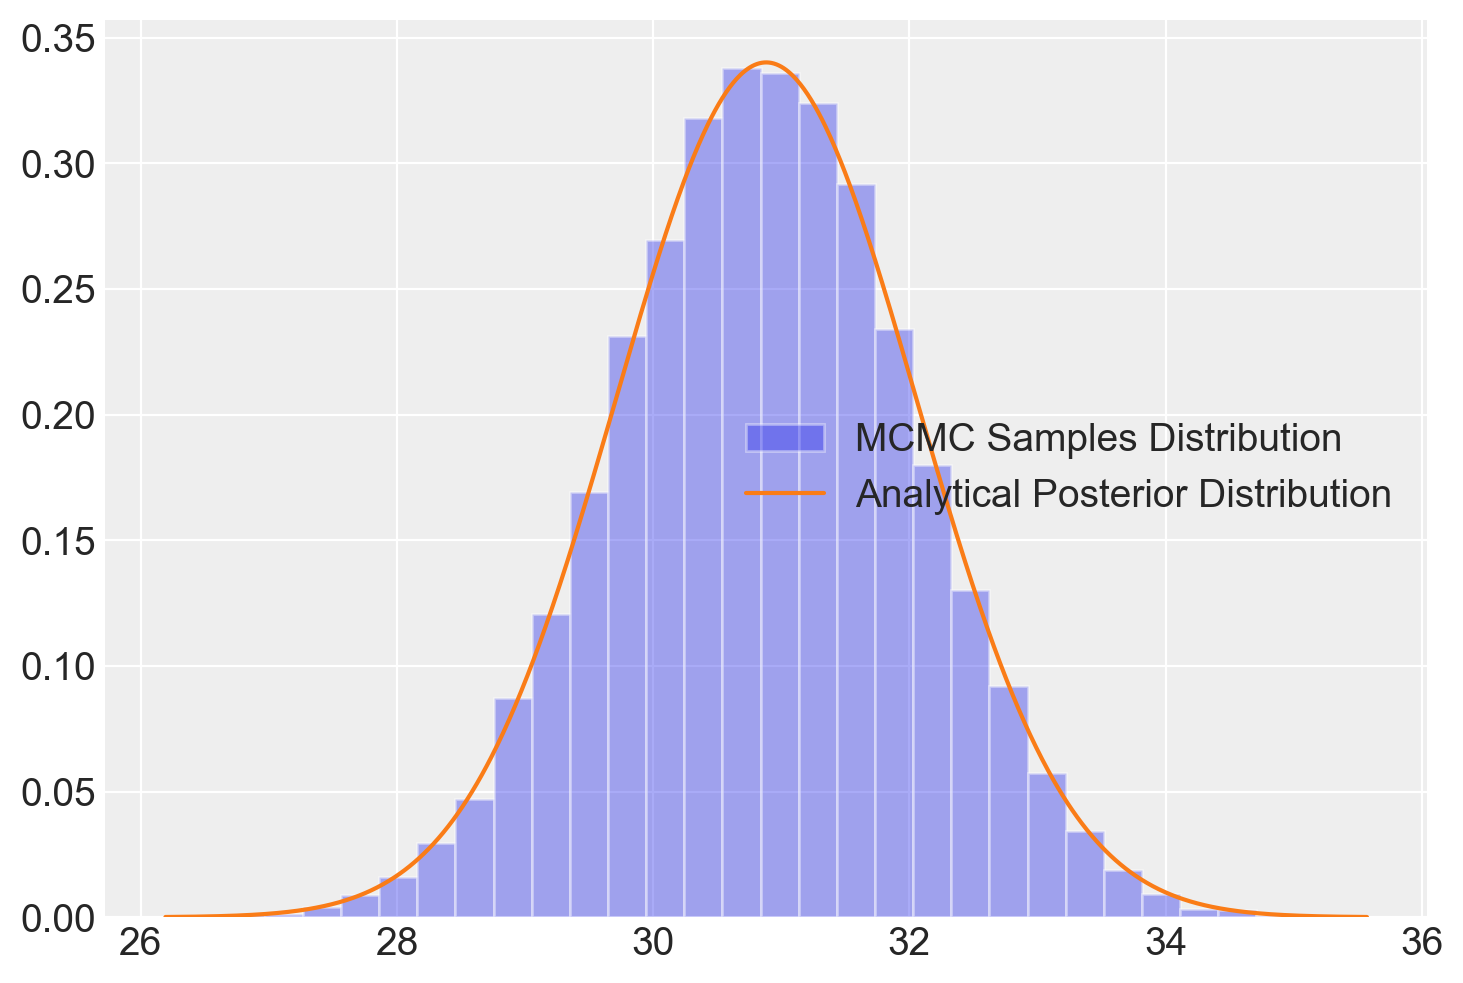

In [52]:
# Parametri del prior
mu_prior = 30
std_prior = 5
var_prior = std_prior ** 2

# Dati osservati
n = len(y)
sum_y = np.sum(y)
var_data = np.var(y, ddof=1)  # ddof=1 for sample variance

# Calcolo dei parametri posterior
mu_post = (mu_prior / var_prior + sum_y / var_data) / (1 / var_prior + n / var_data)
var_post = 1 / (1 / var_prior + n / var_data)
std_post = np.sqrt(var_post)

# Generazione dei punti x per il grafico
x = np.linspace(mu_post - 4 * std_post, mu_post + 4 * std_post, 1000)

# Istogramma dei campioni dal posterior
plt.hist(samples[burnin:], bins=30, alpha=0.4, density=True, label="MCMC Samples Distribution")

# Curva della distribuzione posteriore analitica
plt.plot(x, stats.norm.pdf(x, mu_post, std_post), "C1", label="Analytical Posterior Distribution")

plt.legend()
plt.show()

Questo codice mostra come integrare l'analisi MCMC con l'approccio analitico per il caso normale-normale, offrendo sia una visualizzazione dei risultati del sampling che la conferma attraverso la soluzione analitica. 

## Commenti e considerazioni finali 

In generale, la distribuzione a posteriori dei parametri di un modello statistico non può essere determinata per via analitica. Tale problema viene invece affrontato facendo ricorso ad una classe di algoritmi per il campionamento da distribuzioni di probabilità che sono estremamente onerosi dal punto di vista computazionale e che possono essere utilizzati nelle applicazioni pratiche solo grazie alla potenza di calcolo dei moderni computer. Lo sviluppo di software che rendono sempre più semplice l'uso dei metodi MCMC, insieme all'incremento della potenza di calcolo dei computer, ha contribuito a rendere sempre più popolare il metodo dell'inferenza bayesiana che, in questo modo, può essere estesa a problemi di qualunque grado di complessità.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [53]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sat Jun 15 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

sys        : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:35:20) [Clang 16.0.6 ]
matplotlib : 3.8.4
arviz      : 0.18.0
statsmodels: 0.14.2
scipy      : 1.13.1
numpy      : 1.26.4
seaborn    : 0.13.2
pymc       : 5.15.1
pandas     : 2.2.2

Watermark: 2.4.3

